## Тема: Деревья решений

In [90]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

**Реализован критерий останова по глубине дерева. Изменения внесены в функции:**
    **find_best_split(data, labels) и def build_tree(data, labels)**

In [63]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

In [64]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

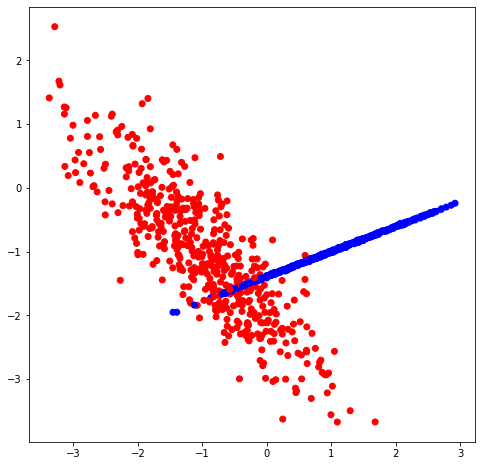

In [65]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [66]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [67]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [68]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [69]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [70]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [56]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
# ИЗМЕНЕНО
#             if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                 continue
# ИЗМЕНЕНО
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [83]:
# Построение дерева с помощью рекурсивной функции

# ИЗМЕНЕНО
# def build_tree(data, labels):
def build_tree(data, labels, max_depth):   

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #  или когда достугнута максимальная глубина дерева
# ИЗМЕНЕНО
    if gain == 0 or max_depth == 0:
# ИЗМЕНЕНО
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
# ИЗМЕНЕНО
#     true_branch = build_tree(true_data, true_labels)
#     false_branch = build_tree(false_data, false_labels)
    true_branch = build_tree(true_data, true_labels, max_depth-1)
    false_branch = build_tree(false_data, false_labels, max_depth-1)
# ИЗМЕНЕНО

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [84]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [85]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [86]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [87]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [91]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=3)
print_tree(my_tree)

Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Индекс 1 <= -1.6646404646216442
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 1 <= -1.4518330557811816
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= 0.08948763365897339
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [92]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [93]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [94]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.14285714285714

In [95]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

94.0

In [96]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

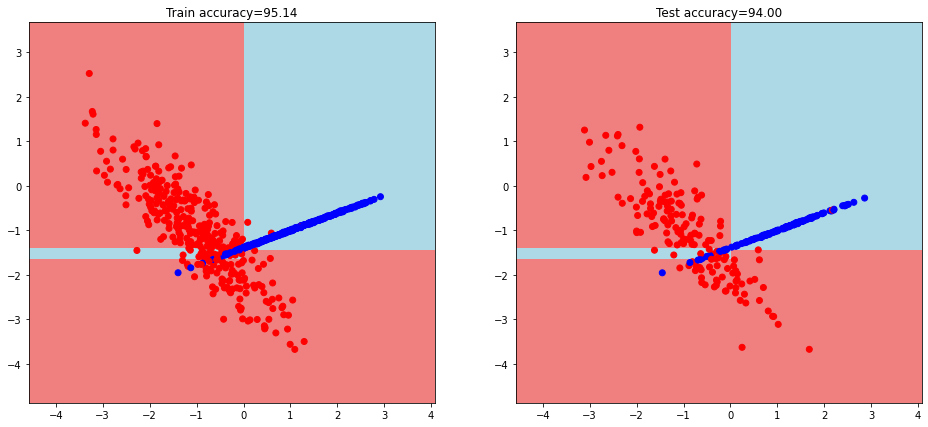

In [97]:
visualize(train_data, test_data)

### 2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [125]:
# сгенерируем данные
regression_data, regression_target = make_regression(n_features=4, n_informative=2, random_state=5)

In [126]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(regression_data, 
                                                                    regression_target, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [127]:
regression_target

array([ -55.14112898,   69.57623511,   41.71439345,  -16.36975704,
        143.12156   ,   18.12870552,   19.78658124,  -39.37871581,
        -32.99062325,  -77.4459446 ,   20.36257967,  -58.67270474,
        -25.90378936,  -48.68546053,  -19.03124825,   91.12332474,
        -55.5342092 ,   36.44789141,  -39.17353519,   80.59187789,
        -22.46877569,  108.00168784,  113.47982365,   87.79278112,
        -11.8346318 ,   67.44168888,  -32.66178223,    1.96793234,
         41.10160076,   24.11120644,   72.63434809,  -51.40731988,
         37.15396921,  -84.27468629,   -6.93608757,  126.51074751,
         68.87791102,   73.0148315 ,  -14.29934949,  143.99731941,
         -1.89778469,  -11.93493935,    1.29572026,  -53.82437313,
          3.45575052,   28.10749957,   15.26610897,  -19.43602854,
         37.29479087,   26.41568785,   25.20499233,  -26.33985265,
        -76.37641882,  -41.48308149,  126.97500496,   15.00976595,
         -7.22733876,   48.86863248,   11.81869147,  180.46747

In [131]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [132]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
# ИЗМЕНЕНО
#         # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов"
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
            
#         # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
#         prediction = max(classes, key=classes.get)
        prediction = np.mean(self.labels)
# ИЗМЕНЕНО
        return prediction 
        

In [133]:
# Расчет критерия Джини
def mse(labels):
# ИЗМЕНЕНО
#def gini(labels):
#     #  подсчет количества объектов разных классов
#     classes = {}
#     for label in labels:
#         if label not in classes:
#             classes[label] = 0
#         classes[label] += 1
    
#     #  расчет критерия
#     impurity = 1
#     for label in classes:
#         p = classes[label] / len(labels)
#         impurity -= p ** 2
        
#     return impurity
# ИЗМЕНЕНО
    return np.mean((labels - labels.mean)**2)

In [119]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [120]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [134]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [135]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [136]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [137]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.21456398452907421
--> True:
  Индекс 0 <= -0.8568531547160899
  --> True:
    Прогноз: -103.14243640050199
  --> False:
    Индекс 0 <= -0.3792249852036208
    --> True:
      Индекс 0 <= -0.6069895355762209
      --> True:
        Прогноз: -48.378747984560874
      --> False:
        Прогноз: -33.312942473413976
    --> False:
      Индекс 0 <= -0.10061434630710828
      --> True:
        Индекс 0 <= -0.23998173469104078
        --> True:
          Прогноз: -19.957889629581807
        --> False:
          Прогноз: -10.242156920791023
      --> False:
        Прогноз: 3.715726276260404
--> False:
  Индекс 0 <= 1.0967647243543643
  --> True:
    Индекс 0 <= 0.6034716026094954
    --> True:
      Индекс 0 <= 0.390420608044887
      --> True:
        Прогноз: 22.330263230499796
      --> False:
        Прогноз: 34.1269262615138
    --> False:
      Индекс 0 <= 0.877152812186743
      --> True:
        Прогноз: 51.96142101264256
      --> False:
        Прогноз: 71.5243931404